In [401]:
import os
import sys

sys.path.append("/home/yuri/github.com/AoesJP/project_pokereader")
sys.path

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [402]:
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import pickle
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import splprep, splev

In [403]:
from pokedex.edges import deformer, draw

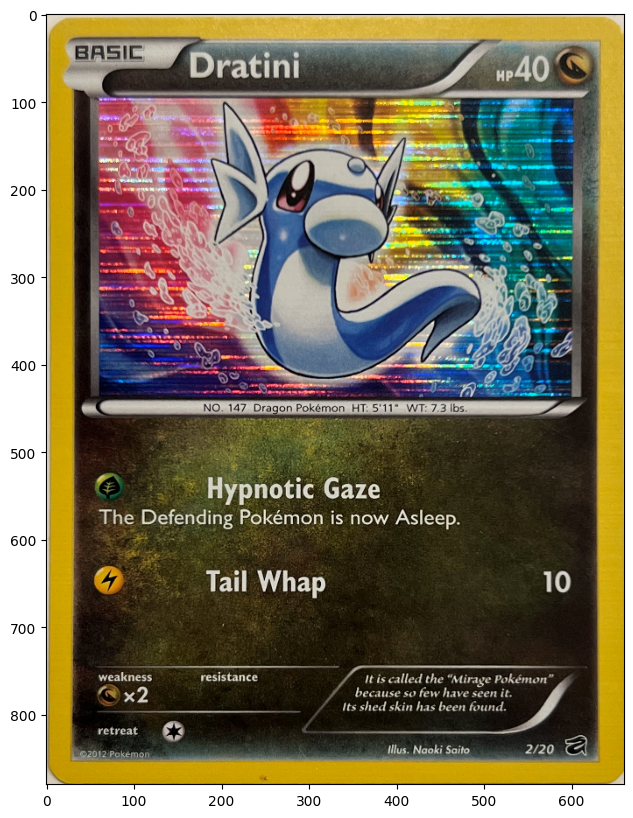

In [404]:
# img_path = "/home/yuri/github.com/AoesJP/project_pokereader/data/white_bg/IMG_1488.jpeg"
# img_path = "/home/yuri/github.com/AoesJP/project_pokereader/data/white_bg/IMG_1498.jpeg"
# img_path = "/home/yuri/github.com/AoesJP/project_pokereader/data/white_bg/swsh12pt5-62.jpg"
img_path = "/home/yuri/github.com/AoesJP/project_pokereader/data/white_bg/dv1-2.jpg"
# img_path = "/home/yuri/github.com/AoesJP/project_pokereader/data/white_bg/charizard2.png"
# img_path = "/home/yuri/github.com/AoesJP/project_pokereader/data/white_bg/pika.jpeg"
# img_path = "/home/yuri/github.com/AoesJP/project_pokereader/data/poke1.png"
# img_path = "/home/yuri/github.com/AoesJP/project_pokereader/data/poke2.png"
deformed_img = deformer.deform_card(img_path)
draw.show_color(deformed_img)

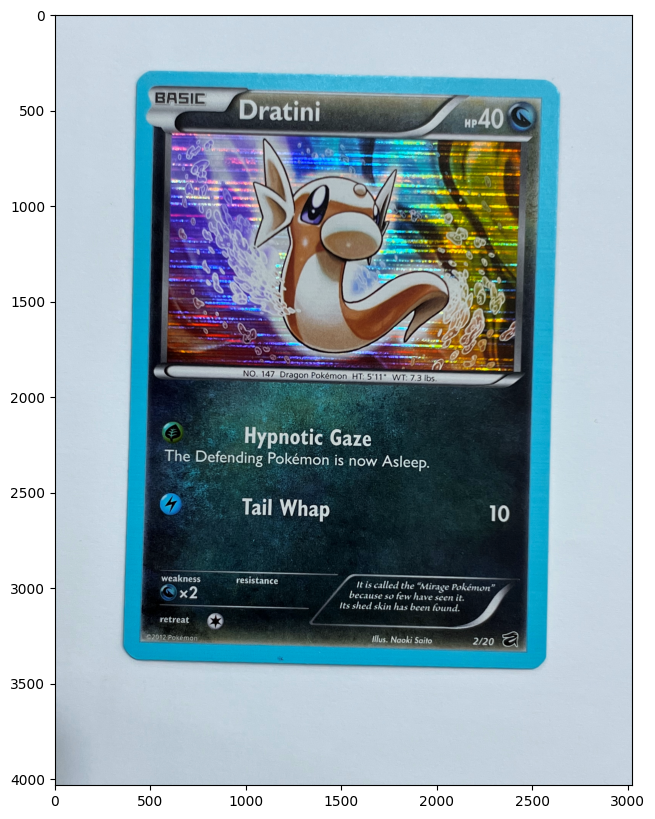

In [405]:
img_orig = cv2.imread(img_path)
draw.show_color(img_orig)

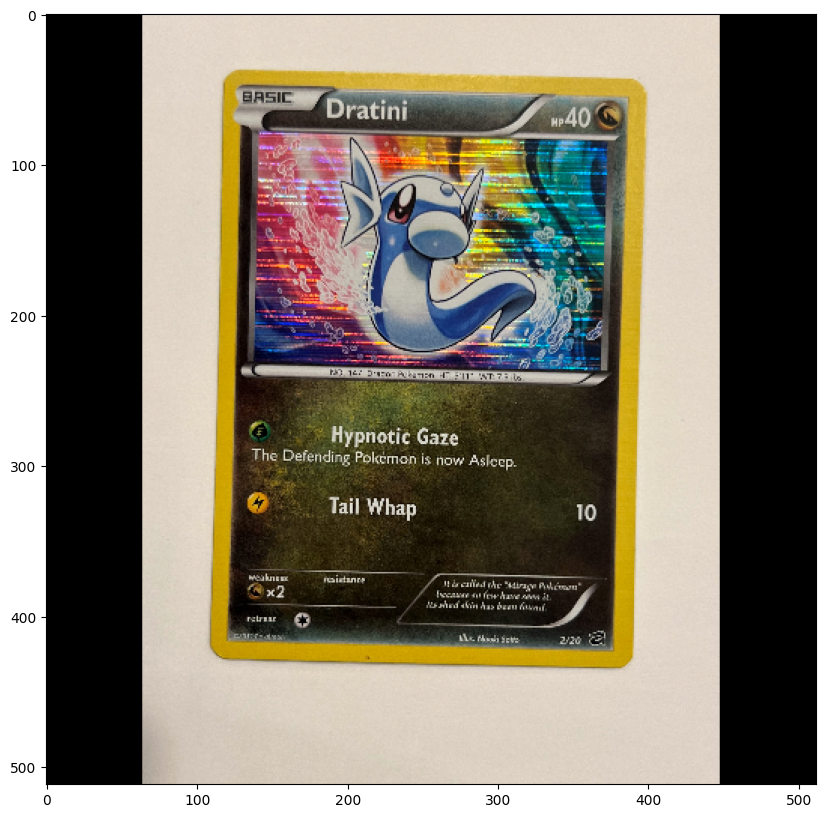

In [406]:
IMG_SIZE = (512, 512)
img = deformer.resize_with_fill(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), IMG_SIZE[0], IMG_SIZE[1])
draw.show_color(img)

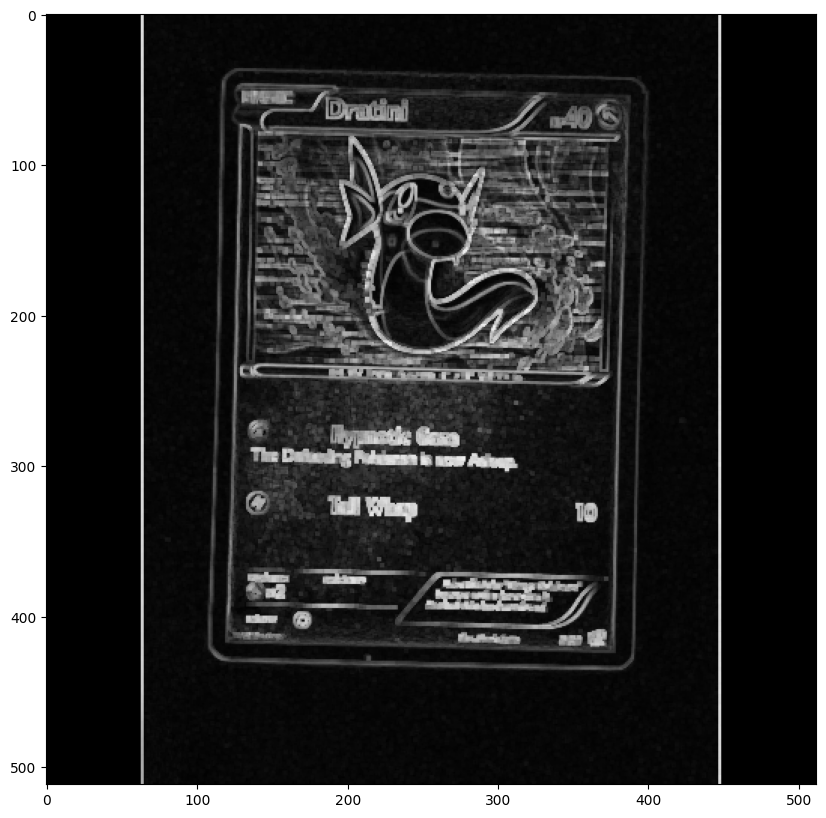

In [407]:
draw.show_grey(cv2.cvtColor(deformer.mono_grad(deformer.apply_blur(img, shift=1), 3), cv2.COLOR_RGB2GRAY))

In [408]:
# corners = cv2.goodFeaturesToTrack(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), 100, 0.01, 10, useHarrisDetector=True, k=0.01)
# img_copy = img.copy()
# corners = np.int0(corners)

# # 検出したコーナー位置に円を描画
# for i in corners:
#     x, y = i.ravel()
#     cv2.circle(img_copy, (x, y), 6, (0, 0, 255), 2)

# plt.imshow(img_copy)

<Figure size 1000x1000 with 0 Axes>

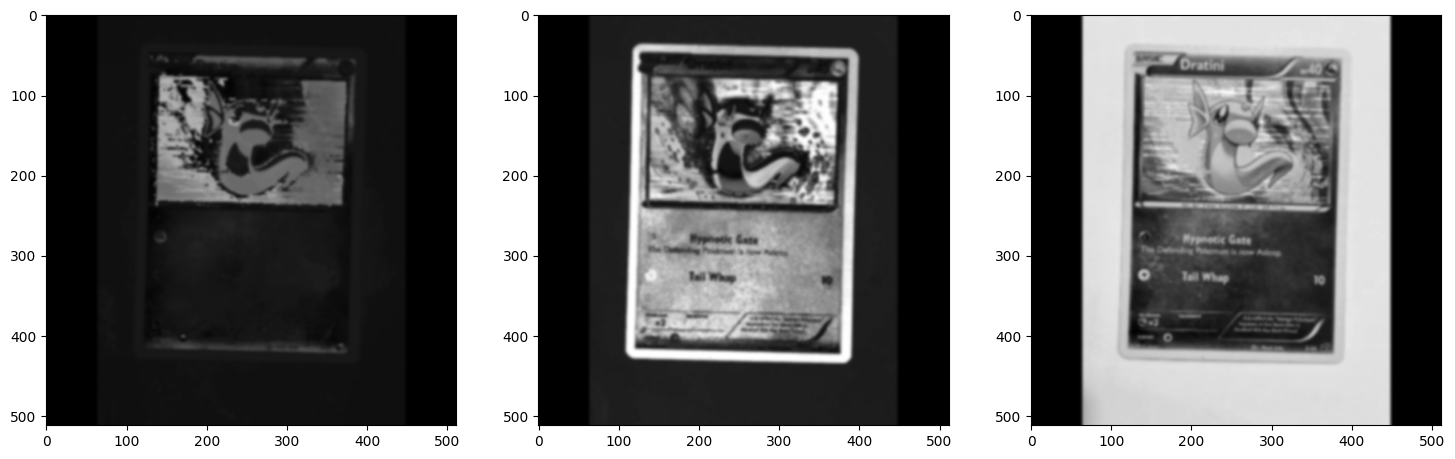

In [409]:
img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
# blurred_rgb = cv2.GaussianBlur(img, (9, 9), 0)
blurred_hsv = cv2.GaussianBlur(img_hsv, (9, 9), 0)
draw.show_channels(blurred_hsv)

<Figure size 1000x1000 with 0 Axes>

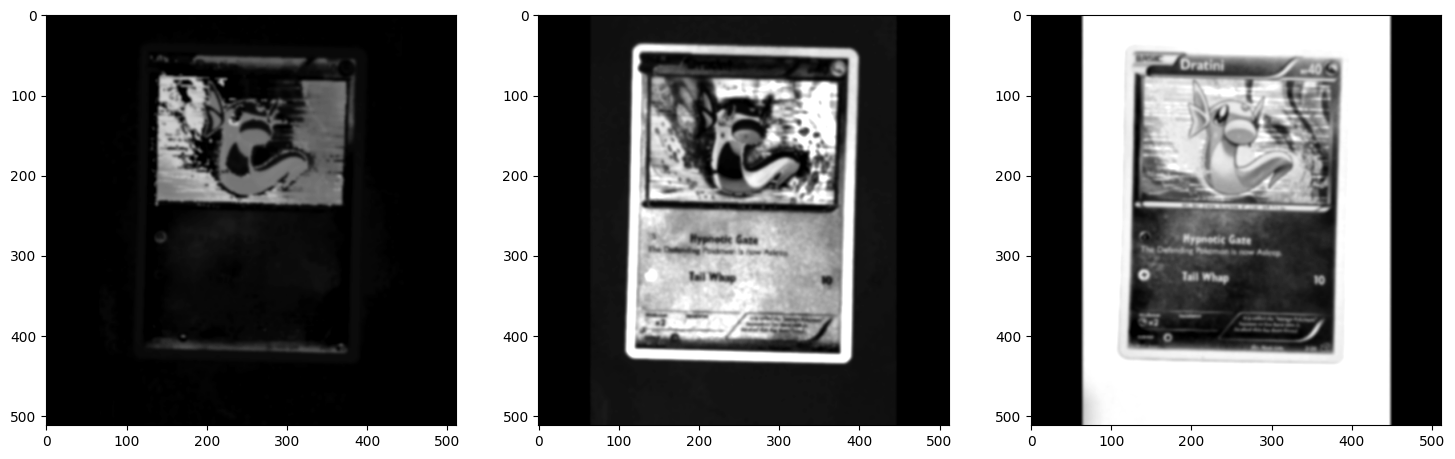

In [410]:
alpha = 1.3
beta = -20
img_h = deformer.apply_contrast(blurred_hsv[:, :, 0], alpha=alpha, beta=beta)
img_s = deformer.apply_contrast(blurred_hsv[:, :, 1], alpha=alpha, beta=beta)
img_v = deformer.apply_contrast(blurred_hsv[:, :, 2], alpha=alpha, beta=beta)
draw.show_channels(np.stack([img_h, img_s, img_v], axis=2))

<Figure size 1000x1000 with 0 Axes>

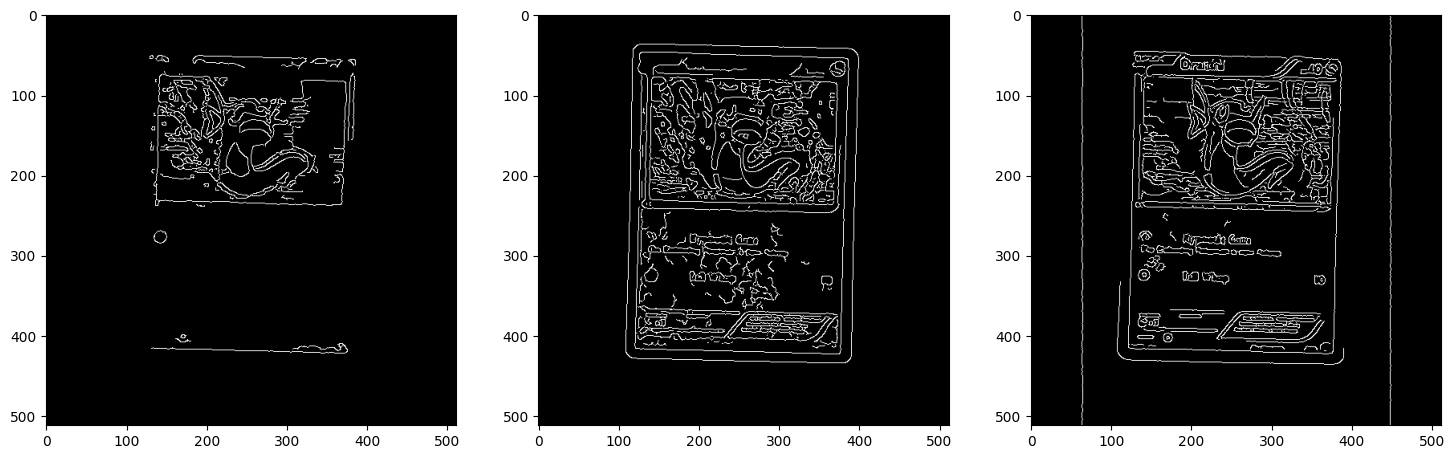

In [412]:
edge1 = cv2.Canny(img_h, 50, 100)
edge2 = cv2.Canny(img_s, 50, 100)
edge3 = cv2.Canny(img_v, 50, 100)
draw.show_channels(np.stack([edge1, edge2, edge3], axis=2))

In [413]:
# edge_all = cv2.max(cv2.max(edge1, edge2), edge3)

# draw.show_grey(edge_all)

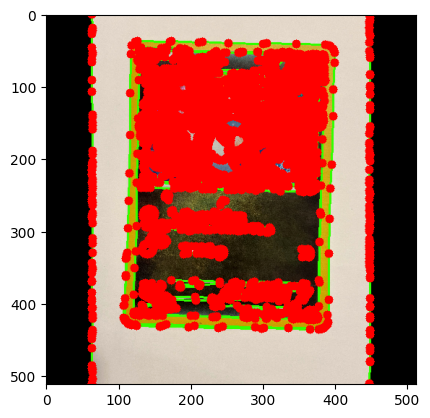

In [415]:
contours_all = []
contours, hierarchy = cv2.findContours(edge1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)
contours_all.extend(list(contours))
contours, hierarchy = cv2.findContours(edge2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)
contours_all.extend(list(contours))
contours, hierarchy = cv2.findContours(edge3, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)
contours_all.extend(list(contours))
draw.draw_contours(img, contours_all)

In [416]:
# contours, hierarchy = cv2.findContours(edge_all, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)
# list(contours)

In [417]:
contours = contours_all

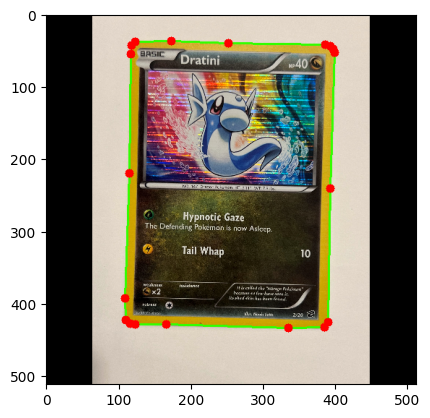

In [418]:
cnt_smoothed = deformer.smooth_contours(contours, epsilon=1)
cnt_smoothed_cleaned = deformer.remove_short_contours(cnt_smoothed)
found_contours = deformer.find_rectangle_contours(cnt_smoothed_cleaned, deformer.base_contour)
if not len(found_contours) > 0:
    deformer.logger.warning("No contour was found. Exiting.")

best_fit_contour = found_contours[0][0]
draw.draw_contour(img, best_fit_contour)

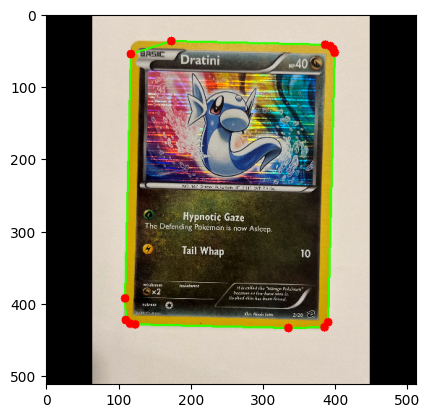

In [420]:
best_fit_contour = deformer.remove_flat_points(best_fit_contour, threshold=2)
draw.draw_contour(img, best_fit_contour)

In [421]:
best_fit_contour = deformer.reset_orientation(best_fit_contour)

In [366]:
1 - np.array([0.2, 6])

array([ 0.8, -5. ])

In [363]:
a = np.array([[1, 2], [3, 4]]) * np.stack([np.array([0.2, 6]), np.array([0.2, 3])], axis=1)
a

array([[ 0.2,  0.4],
       [18. , 12. ]])

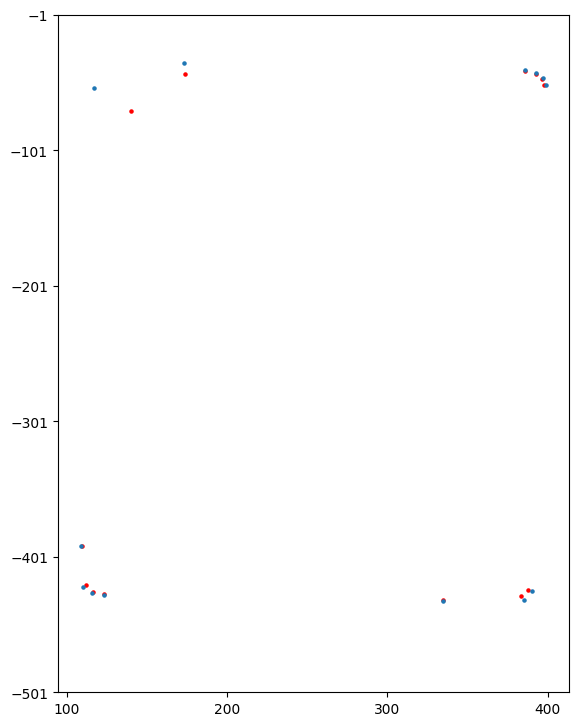

In [422]:
def smooth_contour_points(contour, s=3):
    ctr = np.squeeze(contour, axis=1)
    bck = np.roll(ctr, 1, axis=0)
    fwd = np.roll(ctr, -1, axis=0)
    mid1 = (bck + ctr) * 0.5
    mid2 = (fwd + ctr) * 0.5
    len_b = np.linalg.norm(bck - ctr, axis=1)
    len_f = np.linalg.norm(fwd - ctr, axis=1)
    weight = len_b / (len_f + len_b)

    return mid2 * np.stack([weight, weight], axis=1) + mid1 * np.stack([1 - weight, 1 - weight], axis=1)


reset_c = deformer.reset_orientation(best_fit_contour)
orig = np.squeeze(best_fit_contour, axis=1)
a = smooth_contour_points(reset_c)
plt.figure(figsize=(6.6, 8.8))
plt.scatter(a[:, 0], -a[:, 1], s=5, color="red")
plt.scatter(orig[:, 0], -orig[:, 1], s=5)
_x = plt.xticks(range(100, 401, 100))
_y = plt.yticks(range(-501, 1, 100))

In [267]:
a = np.array([1, 2, 3])
b = np.array([1, 2, 3])
np.stack([a, b, a], axis=1)

array([[1, 1, 1],
       [2, 2, 2],
       [3, 3, 3]])

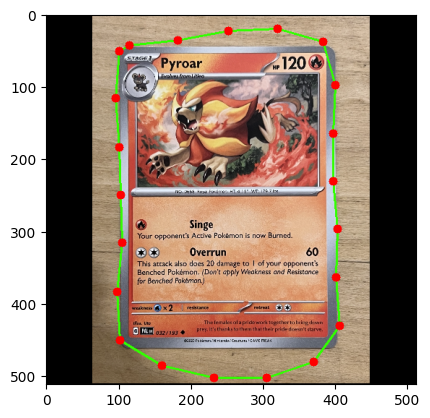

In [258]:
# def smooth_contour_points(contour, s=3):
#     # Convert contour to an array of x and y coordinates
#     contour_array = np.squeeze(contour, axis=1)
#     x = contour_array[:, 0]
#     y = contour_array[:, 1]

#     # Fit a B-spline to the contour points
#     tck, u = splprep([x, y], s=s)

#     # Evaluate the B-spline to get smoothed points
#     x_smooth, y_smooth = splev(np.linspace(0, 1, len(x)), tck)

#     # Combine the smoothed x and y coordinates
#     smoothed_contour = np.stack((x_smooth, y_smooth), axis=-1).astype(np.int32)

#     # Convert to the required contour shape
#     smoothed_contour = smoothed_contour[:, np.newaxis, :]

#     return smoothed_contour


# img_copy = img.copy()
# a = smooth_contour_points(best_fit_contour, s=1)
# a
# draw.draw_contour(img_copy, a)

In [257]:
# def smooth_contour_points(contour: np.ndarray, strength: float = 0.1, sigma=3):
#     # Convert contour to an array of x and y coordinates
#     contour_array = np.squeeze(contour, axis=1)
#     # x = contour_array[:, 0]
#     # y = contour_array[:, 1]

#     # # Apply Gaussian filter to the x and y coordinates separately
#     # x_smooth = gaussian_filter1d(x, sigma=sigma, mode="nearest") * strength + x * (1 - strength)
#     # y_smooth = gaussian_filter1d(y, sigma=sigma, mode="nearest") * strength + y * (1 - strength)
#     blur = cv2.blur(contour_array, ksize=(2, 2))

#     # # Combine the smoothed x and y coordinates
#     # # smoothed_contour = np.stack((x_smooth, y_smooth), axis=-1).astype(np.int32)
#     # smoothed_contour = np.stack((blur[0], blur[1]), axis=-1).astype(np.int32)

#     return np.expand_dims(blur, axis=1).astype(np.int32)


# img_copy = img.copy()
# a = smooth_contour_points(best_fit_contour, strength=0.5, sigma=3)
# draw.draw_contour(img_copy, a)
# a

In [205]:
np.squeeze(best_fit_contour, axis=1).shape

(22, 2)

In [ ]:
cv2.blur()

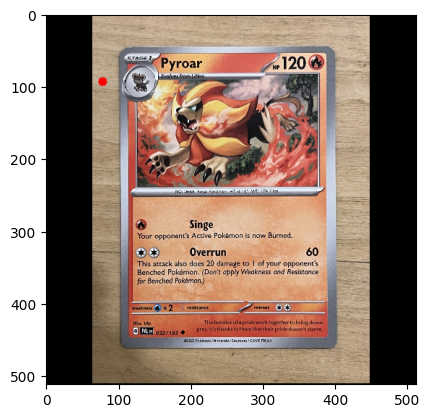

In [207]:
a = smooth_contour_points(best_fit_contour, strength=0.5, sigma=3)
a
draw.draw_contour(img, a)

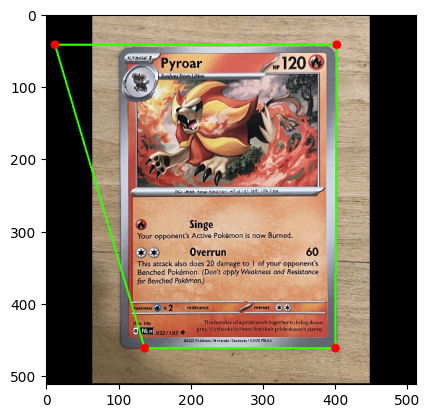

In [34]:
best_fit_contour = deformer.get_corners_from_contour(best_fit_contour)
draw.draw_contour(img, best_fit_contour)